<a href="https://colab.research.google.com/github/zhuzihan728/metal-binding-site-prediction/blob/main/explore_biopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Import Libs

In [ ]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.6 MB/s eta 0:00:00


In [ ]:
import os  
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import iqr

# Extract datasets

In [ ]:
%env MY_PATH=/content/drive/MyDrive/FYP

env: MY_PATH=/content/drive/MyDrive/FYP


In [ ]:
import os

my_path = os.environ['MY_PATH']   
my_path

'/content/drive/MyDrive/FYP'

In [ ]:
!tar -xvf /content/drive/MyDrive/FYP/uniprot_dataset.tar

ChEBI-IDs_for_metal_binding.tsv
POS_TRAIN_FULL.tsv
POS_TRAIN.tsv
NEG_TRAIN.fasta
POS_TRAIN.fasta
POS_TRAIN_FULL.fasta


In [ ]:
!cat NEG_TRAIN.fasta	POS_TRAIN_FULL.fasta > combined.fasta

In [ ]:
total_len = len(list(SeqIO.parse("/content/combined.fasta", "fasta")))
print("Full data set size: ", total_len)

Full data set size:  287027


## Data File Description
ChEBI-IDs_for_metal_binding.tsv: 29 metal ions and their ChEBI-ID.  
  \
POS_TRAIN_FULL.tsv: annotated protein metal binding sites for POS_TRAIN_FULL.fasta.  
  \
POS_TRAIN.tsv: annotated protein metal binding sites for POS_TRAIN.fasta.  
  \
NEG_TRAIN.fasta: negative protein sequences.  
  \
POS_TRIAN.fasta: positive protein sequences annotated by evidence ECO:0000269 and ECO:0007744 from UniProtKB/Swiss-Prot, s subset of POS_TRAIN_FULL.fasta.  
  \
POS_TRAIN_FULL.fasta: all positive protein sequences from UniProtKB/Swiss-Prot, containing POS_TRIAN.fasta.

# Helper functions

In [ ]:
def check_metal_per(seqs, metal, anno, metal_count_df):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  per = cnt / int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
  return per

In [ ]:
def check_metal_num(seqs, metal, anno):
  cnt = 0
  temp = anno.loc[anno['Accession'].isin(seqs)]
  temp1 = temp['ChEBI-ID'].value_counts().to_frame().reset_index()
  row = temp1[temp1['index'] == metal]['ChEBI-ID']
  cnt = 0 if len(row) == 0 else int(row)
  return cnt

In [ ]:
def check_metal_specific_residue_proportion(acc_ls, source = 'POS_TRAIN_FULL.tsv'):
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  for metal in metal_count_df['ChEBI-ID'].unique():
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    num = check_metal_num(acc_ls, metal, anno) 
    total_num = int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
    print(f'{metal:12}| {metal_name:29} | num: {int(num):6} | %: {num/total_num}')

In [ ]:
def write_seq_ls2fasta(file_out, ls, source):
  with open(file_out, 'w') as f_out:
    for seq_record in SeqIO.parse(source, "fasta"):
      seq_acc = seq_record.id.split('|')[1]
      if seq_acc in ls:
        r = SeqIO.write(seq_record, f_out, 'fasta')

        if r!=1: 
          print('Error while writing sequence: ' + seq_acc)
        else:
          print(f'writing {seq_acc} to train fasta file.')

In [ ]:
def fasta2acc_seq_ls(path):
  acc = []
  seq = []

  for seq_record in SeqIO.parse(path, "fasta"):
    acc.append(seq_record.id.split('|')[1])
    seq.append(str(seq_record.seq))
  return acc, seq

In [ ]:
def check_pos_neg_proportion(ls):
  total_num = len(ls)
  
  acc, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  inter = set(acc).intersection(ls)
  pos_num = len(inter)
  neg_num = total_num - pos_num
  pos_portion = pos_num/total_num
  neg_portion = neg_num/total_num
  print(f'total seq in the set: {total_num}')
  print(f'proportion over full dataset: {total_num/total_len}')
  print(f'pos: {pos_num} %: {pos_portion}')
  print(f'neg: {neg_num} %: {neg_portion}')
  return total_num, pos_num, neg_num, pos_portion, neg_portion

In [ ]:
def identity_above_threshold(m8file, thres):
  data = pd.read_csv(m8file, sep="\t", index_col=False, header=None)
  data.columns = ["query", "target","sequence identity","alignment length","mismatch","gap opening", "query domain start position", "end position","target domain start position", "end position", "evalue", "bit score"]
  
  seq_above_thres = data[data["sequence identity"] > thres]["query"].unique()
  seq_below_thres = data[~data["query"].isin(seq_above_thres)]["query"].unique()
  # print(data[data["sequence identity"] > thres]["sequence identity"].unique())
  all_seq = data["query"].unique()
  proportion = len(seq_above_thres) / len(all_seq)
  print(len(all_seq) == len(seq_above_thres) + len(seq_below_thres))
  return seq_above_thres, seq_below_thres, proportion

In [ ]:
def read_fasta(fasta_path, split_char="|", id_field=1):
    '''
        Reads in fasta file containing multiple sequences.
        Split_char and id_field allow to control identifier extraction from header.
        E.g.: set split_char="|" and id_field=1 for SwissProt/UniProt Headers.
        Returns dictionary holding multiple sequences or only single 
        sequence, depending on input file.
    '''
    
    seqs = dict()
    with open( fasta_path, 'r' ) as fasta_f:
        for line in fasta_f:
            # get uniprot ID from header and create new entry
            if line.startswith('>'):
                uniprot_id = line.replace('>', '').strip().split(split_char)[id_field]
                # replace tokens that are mis-interpreted when loading h5
                uniprot_id = uniprot_id.replace("/","_").replace(".","_")
                seqs[ uniprot_id ] = ''
            else:
                # repl. all whie-space chars and join seqs spanning multiple lines, drop gaps and cast to upper-case
                seq= ''.join( line.split() ).upper().replace("-","")
                # repl. all non-standard AAs and map them to unknown/X
                seq = seq.replace('U','X').replace('Z','X').replace('O','X')
                seqs[ uniprot_id ] += seq 
    example_id=next(iter(seqs))
    print("Read {} sequences.".format(len(seqs)))
    print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

    return seqs

In [ ]:
def dataset_metal_binding_summary(acc_ls, source = 'POS_TRAIN_FULL.tsv'):
  total_num = len(acc_ls)
  print(f'total seq in the set: {total_num}')

  all_pos_acc_ls, _ = fasta2acc_seq_ls("POS_TRAIN_FULL.fasta")
  metals = {'CHEBI:29105':0,'CHEBI:18420':1,'CHEBI:49883':2,'CHEBI:29108':3,'CHEBI:29035':4,'CHEBI:60240':5,'CHEBI:24875':6,'CHEBI:190135':7,'CHEBI:23378':8,'CHEBI:29103':9,'CHEBI:49786':10,'CHEBI:29101':11,'CHEBI:29034':12,'CHEBI:30408':13,'CHEBI:29036':14,'CHEBI:29033':15,'CHEBI:21137':16,'CHEBI:49552':17,'CHEBI:48775':18,'CHEBI:48828':19,'CHEBI:21143':20,'CHEBI:25213':21,'CHEBI:47739':22,'CHEBI:16793':23,'CHEBI:177874':24,'CHEBI:60400':25,'CHEBI:49415':26,'CHEBI:60504':27,'CHEBI:49713':28}
  anno = pd.read_csv(source, sep='\t')
  metal_count_df = anno['ChEBI-ID'].value_counts().to_frame().reset_index()
  metal_count_df.columns = ['ChEBI-ID', 'count']
  metal_id_name_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')
  prot_counter = [0]*29 
  res_counter = [0]*29
  pos_acc = set(all_pos_acc_ls).intersection(acc_ls)
  for i, metal in enumerate(metals):
    metal_name = metal_id_name_df[metal_id_name_df['ChEBI-ID']==metal]['Name'].iloc[0]
    temp = anno[anno['ChEBI-ID'] == metal]
    prot_counter[i] += len(temp[temp['Accession'].isin(pos_acc)]['Accession'].unique())
    res_counter[i] += check_metal_num(acc_ls, metal, anno)
    total_res_num = int(metal_count_df[metal_count_df['ChEBI-ID'] == metal]['count'])
    print(f"{metal:13}|{metal_name:30}|#p: {prot_counter[i]:10}|#residue: {res_counter[i]:6}|%residue/all: {res_counter[i]/total_res_num:{5}.{3}}")
  print(f"#non-binding protein: {total_num-len(pos_acc)}")
  return prot_counter, res_counter


# Data preview

ls: all proteins in POS_TRAIN_FULL.fasta.

In [ ]:
pos_dic = read_fasta('POS_TRAIN_FULL.fasta', split_char="|", id_field=1)
pos_acc = list(pos_dic.keys())
pos_seq = list(pos_dic.values())
print(pos_acc[0])
print(pos_seq[0])

Read 93894 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


In [ ]:
neg_dic = read_fasta('NEG_TRAIN.fasta', split_char="|", id_field=1)
neg_acc = list(neg_dic.keys())
neg_seq = list(neg_dic.values())
print(neg_acc[0])
print(neg_seq[0])

Read 193133 sequences.
Example:
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP


In [ ]:
full_dic = read_fasta('combined.fasta', split_char="|", id_field=1)
full_acc = list(full_dic.keys())
full_seq = list(full_dic.values())
print(full_acc[0])
print(full_seq[0])

Read 287027 sequences.
Example:
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP
A0A075B6S6
MRLPAQLLGLLMLWVPGSSGDVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPGQSPRRLIYKVSNWDSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCMQGTHWP


# Filter negative data by MMSEQS clustering
cluster by squence identity > 80% and take the reps.

In [ ]:
!tar -xvf /content/drive/MyDrive/FYP/miniconda -C /root

流式输出内容被截断，只能显示最后 5000 行内容。
miniconda/lib/python3.7/site-packages/conda_env/cli/__pycache__/main_config.cpython-37.pyc
miniconda/lib/python3.7/site-packages/conda_env/cli/main_config.py
miniconda/lib/python3.7/site-packages/conda_env/cli/main.py
miniconda/lib/python3.7/site-packages/conda_env/cli/main_vars.py
miniconda/lib/python3.7/site-packages/conda_env/exceptions.py
miniconda/lib/python3.7/site-packages/conda_env/installers/
miniconda/lib/python3.7/site-packages/conda_env/installers/__init__.py
miniconda/lib/python3.7/site-packages/conda_env/installers/conda.py
miniconda/lib/python3.7/site-packages/conda_env/installers/base.py
miniconda/lib/python3.7/site-packages/conda_env/installers/__pycache__/
miniconda/lib/python3.7/site-packages/conda_env/installers/__pycache__/pip.cpython-37.pyc
miniconda/lib/python3.7/site-packages/conda_env/installers/__pycache__/conda.cpython-37.pyc
miniconda/lib/python3.7/site-packages/conda_env/installers/__pycache__/__init__.cpython-37.pyc
miniconda/lib

In [ ]:
%alias activate $HOME/miniconda/bin/activate

In [ ]:
%alias mmseqs $HOME/miniconda/pkgs/mmseqs2-14.7e284-pl5321hf1761c0_0/bin/mmseqs

In [ ]:
activate tutorial

In [ ]:
mmseqs

MMseqs2 (Many against Many sequence searching) is an open-source software suite for very fast, 
parallelized protein sequence searches and clustering of huge protein sequence data sets.

Please cite: M. Steinegger and J. Soding. MMseqs2 enables sensitive protein sequence searching for the analysis of massive data sets. Nature Biotechnology, doi:10.1038/nbt.3988 (2017).

MMseqs2 Version: 14.7e284
© Martin Steinegger (martin.steinegger@snu.ac.kr)

usage: mmseqs <command> [<args>]

Easy workflows for plain text input/output
  easy-search       	Sensitive homology search
  easy-cluster      	Slower, sensitive clustering
  easy-linclust     	Fast linear time cluster, less sensitive clustering
  easy-taxonomy     	Taxonomic classification
  easy-rbh          	Find reciprocal best hit

Main workflows for database input/output
  search            	Sensitive homology search
  map               	Map nearly identical sequences
  rbh               	Reciprocal best hit search
  linclust          	F

In [ ]:
mmseqs easy-cluster

usage: mmseqs easy-cluster <i:fastaFile1[.gz|.bz2]> ... <i:fastaFileN[.gz|.bz2]> <o:clusterPrefix> <tmpDir> [options]
options:                               
 -c FLOAT                       List matches above this fraction of aligned (covered) residues (see --cov-mode) [0.800]
 --cov-mode INT                 0: coverage of query and target
                                1: coverage of target
                                2: coverage of query
                                3: target seq. length has to be at least x% of query length
                                4: query seq. length has to be at least x% of target length
                                5: short seq. needs to be at least x% of the other seq. length [0]
 --alignment-mode INT           How to compute the alignment:
                                0: automatic
                                1: only score and end_pos
                                2: also start_pos and cov
                                3: also seq.i

In [ ]:
mmseqs easy-cluster NEG_TRAIN.fasta NEG_clustered tmp --cov-mode 5 -c 0.25 --min-seq-id 0.8

Create directory tmp
easy-cluster NEG_TRAIN.fasta NEG_clustered tmp --cov-mode 5 -c 0.25 --min-seq-id 0.8 

MMseqs Version:                     	14.7e284
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.25
Coverage mode                       	5
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask residues probability  

In [ ]:
print("#neg before filtering: ", len(neg_acc))

#neg before filtering:  193133


In [ ]:
fneg_dic = read_fasta('NEG_clustered_rep_seq.fasta', split_char="|", id_field=1)
fneg_acc = list(fneg_dic.keys())
fneg_seq = list(fneg_dic.values())
print(fneg_acc[0])
print(fneg_seq[0])

Read 101183 sequences.
Example:
P0A826
MLKREMNIADYDAELWQAMEQEKVRQEEHIELIASENYTSPRVMQAQGSQLTNKYAEGYPGKRYYGGCEYVDIVEQLAIDRAKELFGADYANVQPHSGSQANFAVYTALLEPGDTVLGMNLAHGGHLTHGSPVNFSGKLYNIVPYGIDATGHIDYADLEKQAKEHKPKMIIGGFSAYSGVVDWAKMREIADSIGAYLFVDMAHVAGLVAAGVYPNPVPHAHVVTTTTHKTLAGPRGGLILAKGGSEELYKKLNSAVFPGGQGGPLMHVIAGKAVALKEAMEPEFKTYQQQVAKNAKAMVEVFLERGYKVVSGGTDNHLFLVDLVDKNLTGKEADAALGRANITVNKNSVPNDPKSPFVTSGIRVGTPAITRRGFKEAEAKELAGWMCDVLDSINDEAVIERIKGKVLDICARYPVYA
P0A826
MLKREMNIADYDAELWQAMEQEKVRQEEHIELIASENYTSPRVMQAQGSQLTNKYAEGYPGKRYYGGCEYVDIVEQLAIDRAKELFGADYANVQPHSGSQANFAVYTALLEPGDTVLGMNLAHGGHLTHGSPVNFSGKLYNIVPYGIDATGHIDYADLEKQAKEHKPKMIIGGFSAYSGVVDWAKMREIADSIGAYLFVDMAHVAGLVAAGVYPNPVPHAHVVTTTTHKTLAGPRGGLILAKGGSEELYKKLNSAVFPGGQGGPLMHVIAGKAVALKEAMEPEFKTYQQQVAKNAKAMVEVFLERGYKVVSGGTDNHLFLVDLVDKNLTGKEADAALGRANITVNKNSVPNDPKSPFVTSGIRVGTPAITRRGFKEAEAKELAGWMCDVLDSINDEAVIERIKGKVLDICARYPVYA


In [ ]:
!cat POS_TRAIN_FULL.fasta NEG_clustered_rep_seq.fasta > filtered_combined.fasta

prot_df:  combined.fasta['Accession', 'Prot_seq'] \
metalb_df:  POS_TRAIN_FULL.tsv (col: Accession,	Evidence,	ChEBI-ID,	Position) \
metal_id_name_df: ChEBI-IDs_for_metal_binding.tsv (col: ChEBI-ID,	Name,	ChEBI-ID Parents)

# Dataset Analysis

In [ ]:
full_dic = read_fasta('filtered_combined.fasta', split_char="|", id_field=1)
full_acc = list(full_dic.keys())
full_seq = list(full_dic.values())
print(full_acc[0])
print(full_seq[0])

Read 195077 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


In [ ]:
prot_df = pd.DataFrame({'Accession': full_acc, 'Prot_seq': full_seq})
 
label_df = pd.read_csv('POS_TRAIN_FULL.tsv', sep='\t')
 
metal_df = pd.read_csv('ChEBI-IDs_for_metal_binding.tsv', sep='\t')

In [ ]:
#@title Full (positive + negative) proteins. { display-mode: "form" }
prot_df

,Accession,Prot_seq
0,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...
1,A0A023GS28,MAPTKDFSTTTTNGAESWDDVADFVTKKGHGVKGLSERGIKTLPKP...
2,A0A023GS29,MAPTKDFSTATNGADSWDDVADFVTKKGHGVKGLSERGIKTLPKPF...
3,A0A023YYV9,MLSPIRTTFHNSVNIVQSSPCQTVSFAGKEYELKVIDEKTPILFQW...
4,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...
...,...,...
195072,Q1I301,MERQLEAYCAHLRNERQVSGHTLLAYRRDLEKVIEFCNNQGIAGWD...
195073,Q1LVQ7,MEYLSDKFSLKSPAIKGSDYYMDQVMDTLDNVQYYNKASPKCVQAF...
195074,Q1QVU4,MSRTAFFISDGTGITAETLGRSLLAQFEGVDLTLVVKPYIDTLEKA...
195075,Q1WM15,MAAVEAEKVVAELRERCATPASLLRDVAAAMAGEMGAGLEKEGGSR...


In [ ]:
#@title All labels. { display-mode: "form" }
label_df

,Accession,Evidence,ChEBI-ID,Position
0,P0C6X8,ECO:0000255,CHEBI:29105,6190
1,P0C6X8,ECO:0000255,CHEBI:29105,6376
2,Q9RS27,ECO:0000255,CHEBI:29105,693
3,Q5HLY0,ECO:0000255,CHEBI:18420,97
4,Q9I2T1,ECO:0000255,CHEBI:29105,170
...,...,...,...,...
409984,C5JYZ5,ECO:0000255,CHEBI:60240,318
409985,C5JYZ5,ECO:0000255,CHEBI:60240,446
409986,A7FLX7,ECO:0000255,CHEBI:60240,8
409987,A7FLX7,ECO:0000255,CHEBI:60240,44


In [ ]:
#@title All metal types. { display-mode: "form" }
metal_df

,ChEBI-ID,Name,ChEBI-ID Parents
0,CHEBI:48775,Cd(2+),"CHEBI:60240,CHEBI:25213"
1,CHEBI:29108,Ca(2+),"CHEBI:60240,CHEBI:25213"
2,CHEBI:48828,Co(2+),"CHEBI:60240,CHEBI:25213"
3,CHEBI:49415,Co(3+),CHEBI:25213
4,CHEBI:23378,Cu cation,CHEBI:25213
5,CHEBI:49552,Cu(+),"CHEBI:23378,CHEBI:25213"
6,CHEBI:29036,Cu(2+),"CHEBI:23378,CHEBI:60240,CHEBI:25213"
7,CHEBI:60240,a divalent metal cation,CHEBI:25213
8,CHEBI:190135,[2Fe-2S] cluster,CHEBI:30408
9,CHEBI:24875,Fe cation,CHEBI:25213


In [ ]:
#@title Merged data and labels.
prot_label_df = pd.merge(prot_df, label_df, on = "Accession", how = "outer")
prot_metal_df =  pd.merge(prot_label_df, metal_df, on = "ChEBI-ID", how = "outer")
prot_metal_df

,Accession,Prot_seq,Evidence,ChEBI-ID,Position,Name,ChEBI-ID Parents
0,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,19.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
1,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000250,CHEBI:29108,208.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
2,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,14.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
3,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,12.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
4,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,ECO:0000269,CHEBI:29108,10.0,Ca(2+),"CHEBI:60240,CHEBI:25213"
...,...,...,...,...,...,...,...
511167,Q1I301,MERQLEAYCAHLRNERQVSGHTLLAYRRDLEKVIEFCNNQGIAGWD...,NaN,NaN,NaN,NaN,NaN
511168,Q1LVQ7,MEYLSDKFSLKSPAIKGSDYYMDQVMDTLDNVQYYNKASPKCVQAF...,NaN,NaN,NaN,NaN,NaN
511169,Q1QVU4,MSRTAFFISDGTGITAETLGRSLLAQFEGVDLTLVVKPYIDTLEKA...,NaN,NaN,NaN,NaN,NaN
511170,Q1WM15,MAAVEAEKVVAELRERCATPASLLRDVAAAMAGEMGAGLEKEGGSR...,NaN,NaN,NaN,NaN,NaN


# Metal Occurrence Analysis

,Metal,ChEBI-ID,Count
0,Zn(2+),CHEBI:29105,133807
1,Mg(2+),CHEBI:18420,89414
2,[4Fe-4S] cluster,CHEBI:49883,51607
3,Ca(2+),CHEBI:29108,42179
4,Mn(2+),CHEBI:29035,22438
5,a divalent metal cation,CHEBI:60240,18192
6,Fe cation,CHEBI:24875,17448
7,[2Fe-2S] cluster,CHEBI:190135,9036
8,Cu cation,CHEBI:23378,7395
9,K(+),CHEBI:29103,6266


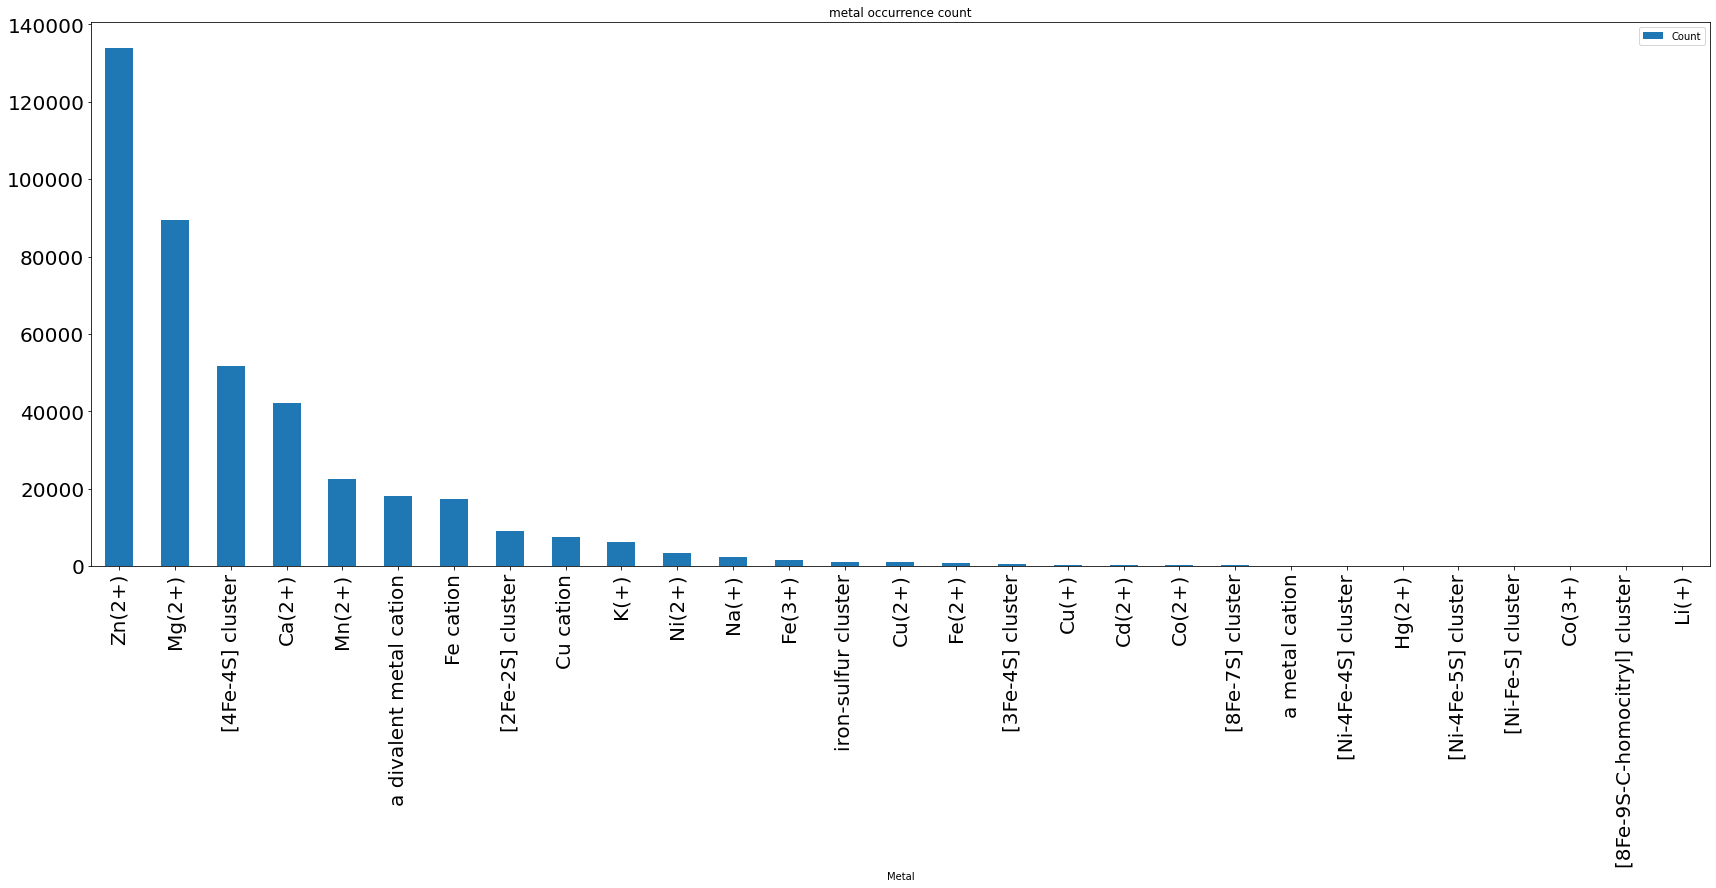

In [ ]:
metal_count_df = prot_metal_df[['Name', 'ChEBI-ID']].value_counts().to_frame().reset_index().rename(columns={'Name':'Metal', 0:'Count'})
metal_count_df.plot(x="Metal", y="Count", kind="bar", figsize=(29,10), fontsize=20, title='metal occurrence count')
metal_count_df
# hg2 -> 5
# co3+, Li -> a metal cation
# fs - 3f4s -> iron-sulfur cluster
# 


## Binding Metal Counts of Proteins

In [ ]:
prot_count_df = prot_metal_df['Accession'].value_counts().to_frame().reset_index().rename(columns={'index':'Accession', 'Accession':'#binding sites'})
prot_count_df

,Accession,#binding sites
0,O31526,88
1,E0VIU9,84
2,O31527,81
3,Q9Y4X5,72
4,Q7KTX7,63
...,...,...
195072,Q9JMG2,1
195073,Q9FWS1,1
195074,Q9FL17,1
195075,Q9CMK1,1


A0A023GPI8  CHEBI:29108        10 \
A0A023GPI8  CHEBI:29035        10 \
shows **one protein can bind two different metals at the same position, provided by the same evidence**.

In [ ]:
temp = prot_metal_df[['Accession', 'ChEBI-ID', 'Position']].dropna(how='any')
temp[temp['Accession']=='A0A023GPI8']

,Accession,ChEBI-ID,Position
0,A0A023GPI8,CHEBI:29108,19.0
1,A0A023GPI8,CHEBI:29108,208.0
2,A0A023GPI8,CHEBI:29108,14.0
3,A0A023GPI8,CHEBI:29108,12.0
4,A0A023GPI8,CHEBI:29108,10.0
42179,A0A023GPI8,CHEBI:29035,24.0
42180,A0A023GPI8,CHEBI:29035,19.0
42181,A0A023GPI8,CHEBI:29035,10.0
42182,A0A023GPI8,CHEBI:29035,8.0


The maximum types of metal one seq can bind is 3.

In [ ]:
# max_num = -1
# for i in range(len(prot_df)):
#   prot = prot_df['Accession'].iloc[i]
#   num = len(temp[temp['Accession'] == prot]['ChEBI-ID'].unique())
#   max_num = max(max_num, num)
# print(max_num)

# Protein Length Analysis

In [ ]:
prot_len_df = pd.DataFrame({'Accession':prot_df['Accession'], 'Prot_seq': prot_df['Prot_seq'], 'Length':[len(i) for i in prot_df['Prot_seq']]})
prot_len_df

,Accession,Prot_seq,Length
0,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,237
1,A0A023GS28,MAPTKDFSTTTTNGAESWDDVADFVTKKGHGVKGLSERGIKTLPKP...,369
2,A0A023GS29,MAPTKDFSTATNGADSWDDVADFVTKKGHGVKGLSERGIKTLPKPF...,369
3,A0A023YYV9,MLSPIRTTFHNSVNIVQSSPCQTVSFAGKEYELKVIDEKTPILFQW...,326
4,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,3423
...,...,...,...
195072,Q1I301,MERQLEAYCAHLRNERQVSGHTLLAYRRDLEKVIEFCNNQGIAGWD...,299
195073,Q1LVQ7,MEYLSDKFSLKSPAIKGSDYYMDQVMDTLDNVQYYNKASPKCVQAF...,320
195074,Q1QVU4,MSRTAFFISDGTGITAETLGRSLLAQFEGVDLTLVVKPYIDTLEKA...,277
195075,Q1WM15,MAAVEAEKVVAELRERCATPASLLRDVAAAMAGEMGAGLEKEGGSR...,458


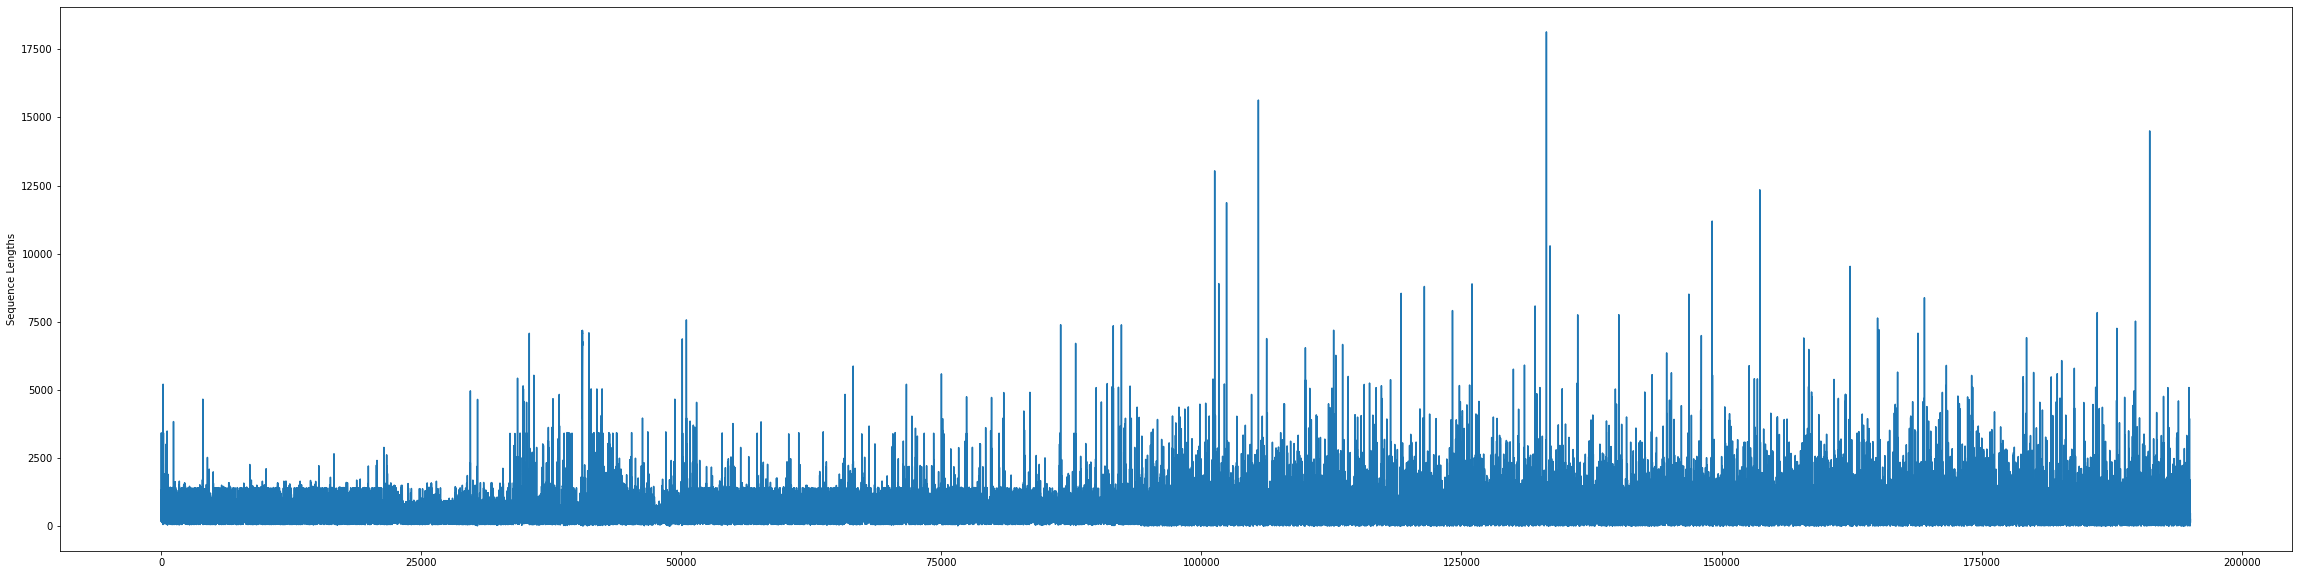

In [ ]:
# Plot out the data
plt.figure(figsize=(40, 10))
plt.plot(prot_len_df['Length'])

plt.ylabel('Sequence Lengths')
plt.show()

## Remove outliers (mean +- 1.5*iqr)

In [ ]:
iqr_ = iqr(prot_len_df['Length'])
mean = np.mean(prot_len_df['Length'])
print('IQR : ', iqr_)
print('Mean : ', mean)

IQR :  273.0
Mean :  446.6423361031798


In [ ]:
# Holds quartile range
qr = list()
[qr.append(abs(row[3]-mean)) for row in prot_len_df.itertuples()]

qr_ndarray = np.array(qr)

In [ ]:
num_before = len(prot_len_df)

mask = qr_ndarray <= (1.5 * iqr_)
prot_trimed_len_df = prot_len_df[mask]

print("Before using IQR : ", num_before)
print("After using IQR : ", len(prot_trimed_len_df))

Before using IQR :  195077
After using IQR :  177367


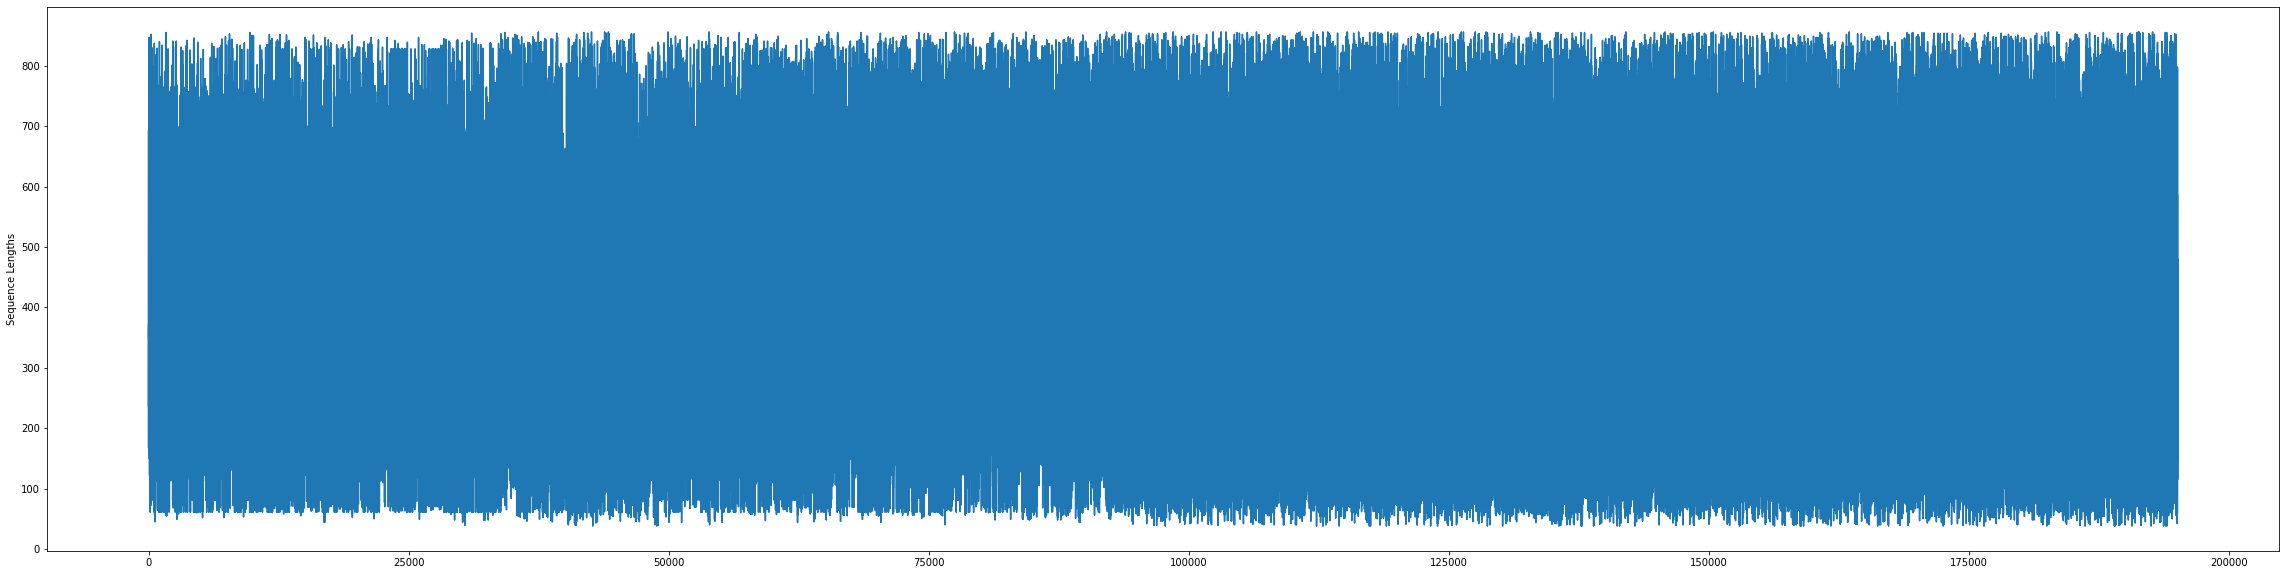

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(prot_trimed_len_df['Length'])
plt.ylabel('Sequence Lengths')
plt.show()

In [ ]:
iqr_ = iqr(prot_trimed_len_df['Length'])
mean = np.mean(prot_trimed_len_df['Length'])
print('IQR : ', iqr_)
print('Mean : ', mean)

IQR :  234.0
Mean :  366.8251591333224


In [ ]:
trimed_acc = list(prot_trimed_len_df['Accession'])
len(trimed_acc)

177367

In [ ]:
write_seq_ls2fasta('trimed_combined.fasta', trimed_acc, 'filtered_combined.fasta')

流式输出内容被截断，只能显示最后 5000 行内容。
writing Q01838 to train fasta file.
writing Q02287 to train fasta file.
writing Q05015 to train fasta file.
writing Q0I2N7 to train fasta file.
writing Q0I6M0 to train fasta file.
writing Q0I8J0 to train fasta file.
writing Q0IHI1 to train fasta file.
writing Q0ILZ4 to train fasta file.
writing Q0K889 to train fasta file.
writing Q0K9H3 to train fasta file.
writing Q0WRX3 to train fasta file.
writing Q10931 to train fasta file.
writing Q118P4 to train fasta file.
writing Q11Y53 to train fasta file.
writing Q12SC6 to train fasta file.
writing Q13PC1 to train fasta file.
writing Q18312 to train fasta file.
writing Q9FXI5 to train fasta file.
writing Q9MIY0 to train fasta file.
writing Q9NAN2 to train fasta file.
writing Q9NX14 to train fasta file.
writing Q9P1W9 to train fasta file.
writing Q9SIE1 to train fasta file.
writing Q9T0I8 to train fasta file.
writing Q9USK2 to train fasta file.
writing Q9VJF2 to train fasta file.
writing Q9VUK5 to train fasta file.
w

# Trimed data analysis

In [ ]:
trimed_dic = read_fasta('trimed_combined.fasta', split_char="|", id_field=1)
trimed_acc = list(trimed_dic.keys())
trimed_seq = list(trimed_dic.values())

Read 177367 sequences.
Example:
A0A023GPI8
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN


In [ ]:
check_pos_neg_proportion(trimed_acc)

total seq in the set: 177367
proportion over full dataset: 0.617945350089016
pos: 87145 %: 0.49132589489589384
neg: 90222 %: 0.5086741051041062


(177367, 87145, 90222, 0.49132589489589384, 0.5086741051041062)

In [ ]:
check_metal_specific_residue_proportion(trimed_acc)

CHEBI:29105 | Zn(2+)                        | num: 109557 | %: 0.8187688237536153
CHEBI:18420 | Mg(2+)                        | num:  80898 | %: 0.9047576442167893
CHEBI:49883 | [4Fe-4S] cluster              | num:  49857 | %: 0.9660898715290561
CHEBI:29108 | Ca(2+)                        | num:  37010 | %: 0.8774508641741151
CHEBI:29035 | Mn(2+)                        | num:  21883 | %: 0.9752651751493003
CHEBI:60240 | a divalent metal cation       | num:  17704 | %: 0.9731750219876869
CHEBI:24875 | Fe cation                     | num:  16869 | %: 0.9668156808803301
CHEBI:190135| [2Fe-2S] cluster              | num:   8595 | %: 0.951195219123506
CHEBI:23378 | Cu cation                     | num:   7001 | %: 0.9467207572684246
CHEBI:29103 | K(+)                          | num:   6218 | %: 0.992339610596872
CHEBI:49786 | Ni(2+)                        | num:   3395 | %: 1.0
CHEBI:29101 | Na(+)                         | num:   2070 | %: 0.9265890778871978
CHEBI:29034 | Fe(3+)             

In [ ]:
dataset_metal_binding_summary(trimed_acc, source = 'POS_TRAIN_FULL.tsv')
pass

total seq in the set: 177367
CHEBI:29105  |Zn(2+)                        |#p:      24756|#residue: 109557|%residue/all: 0.819
CHEBI:18420  |Mg(2+)                        |#p:      30951|#residue:  80898|%residue/all: 0.905
CHEBI:49883  |[4Fe-4S] cluster              |#p:      10793|#residue:  49857|%residue/all: 0.966
CHEBI:29108  |Ca(2+)                        |#p:       4614|#residue:  37010|%residue/all: 0.877
CHEBI:29035  |Mn(2+)                        |#p:       4989|#residue:  21883|%residue/all: 0.975
CHEBI:60240  |a divalent metal cation       |#p:       4401|#residue:  17704|%residue/all: 0.973
CHEBI:24875  |Fe cation                     |#p:       4760|#residue:  16869|%residue/all: 0.967
CHEBI:190135 |[2Fe-2S] cluster              |#p:       2597|#residue:   8595|%residue/all: 0.951
CHEBI:23378  |Cu cation                     |#p:       1399|#residue:   7001|%residue/all: 0.947
CHEBI:29103  |K(+)                          |#p:       2255|#residue:   6218|%residue/all: 0.992
C